# Midterm project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import xgboost as xgb

from itertools import combinations, islice
from math import comb
from pathlib import Path

from tqdm import tqdm

from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.feature_extraction import DictVectorizer
# from sklearn.metrics import root_mean_squared_error
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.tree import export_text

# Dataset

## Loading the dataset

The dataset is called "abalone" by Nash, W. et al. and is available at https://doi.org/10.24432/C55C7W (the UCI Machine Learning Repository).

"Abalone" has a CC BY 4.0 license.

We can import the dataset using the `fetch_ucirepo` package for Python. Note that we need an active internet connection for the `fetch_ucirepo` function to work because it downloads the specified dataset every time it runs.

Check the [UCI Machine Learning Repository for "abalone"](https://archive.ics.uci.edu/dataset/1/abalone) to get more details on how to load the dataset in memory when importing it using `fetch_ucirepo`.

In [2]:
dataset_path = Path("data/abalone.data")

variables = [
    "Sex",
    "Length",
    "Diameter",
    "Height",
    "Whole_weight",
    "Shucked_weight",
    "Viscera_weight",
    "Shell_weight",
    "Rings",
]
dtypes = [
    "object",
    "float64",
    "float64",
    "float64",
    "float64",
    "float64",
    "float64",
    "float64",
    "int64",
]

features = variables[0:-1]
target = variables[-1]

if dataset_path.exists():
    data = pd.read_csv(
        dataset_path,
        names=variables,
        dtype={feature: dtype for feature, dtype in zip(variables, dtypes)},
    )
else:
    try:
        from ucimlrepo import fetch_ucirepo

        # fetch dataset
        abalone = fetch_ucirepo(id=1)
        # extract data
        data = pd.concat([abalone.data.features, abalone.data.targets], axis=1)
    except ModuleNotFoundError:
        print("Please install the `fetch_ucirepo` Python package to get the dataset.")
        print(
            "If you do have the dataset, store 'abalone.data' in './data/' and try again"
        )
        sys.exit(1)
    except ConnectionError:
        print(
            "Error connecting to server. Check your internet connection and try again"
        )
        sys.exit(1)

data.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## Metadata

We reproduce here the dataset information that appears both in the `abalone.names` file (included in the `abalone.zip` file when downloading it by hand) and the "Variables Table" section in the [dataset's webpage](https://archive.ics.uci.edu/dataset/1/abalone):

| Name            | Data Type   | Meas.   | Description                         |
|-----------------|-------------|---------|-------------------------------------|
| Sex             | nominal     |         | M, F, and I (infant)                |
| Length          | continuous  | mm      | Longest shell measurement           |
| Diameter        | continuous  | mm      | Perpendicular to length             |
| Height          | continuous  | mm      | With meat in shell                  |
| Whole weight    | continuous  | grams   | Whole abalone                       |
| Shucked weight  | continuous  | grams   | Weight of meat                      |
| Viscera weight  | continuous  | grams   | Gut weight (after bleeding)         |
| Shell weight    | continuous  | grams   | After being dried                   |
| Rings           | integer     |         | +1.5 gives the age in years         |

# Exploratory data analysis

## Dimensions

The dataset has 4177 records and 8 features.

In [3]:
print(f"Number of records (instances)   : {data.shape[0]}")
print(f"Number of features (attributes) : {data.shape[1] - 1}")

Number of records (instances)   : 4177
Number of features (attributes) : 8


## Data types

The feature "Sex" is categorical and contains the categories `M` (masculine), `F` (feminine) and `I` (infant). The rest of the features contain real numbers. The target "Rings" contains integers.

In [4]:
print(data.dtypes)

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole_weight      float64
Shucked_weight    float64
Viscera_weight    float64
Shell_weight      float64
Rings               int64
dtype: object


In [5]:
print(f"Sex categories: {pd.unique(data.Sex)}")

Sex categories: ['M' 'F' 'I']


And, as we saw in the Metadata section, these are the units of the continuous variables:

- Length: mm
- Diameter: mm
- Height: mm
- Whole weight: grams
- Shucked weight: grams
- Viscera weight: grams
- Shell weight: grams

## Summary statistics

We provide here summary statistics for the numerical variables.

In [6]:
data.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


## Missing values

The dataset has no missing values denoted as such.

In [7]:
print(pd.DataFrame({"Σ null": data.isnull().sum(), "dtype": data.dtypes}))

                Σ null    dtype
Sex                  0   object
Length               0  float64
Diameter             0  float64
Height               0  float64
Whole_weight         0  float64
Shucked_weight       0  float64
Viscera_weight       0  float64
Shell_weight         0  float64
Rings                0    int64


But, as the summary statistics show, we have some "Heigh" records that are equal to 0. These could be interpreted as missing values. There aren't other features that have measurements equal to 0. The target variable doesn't have records equal to 0 either.

In [8]:
data[data["Height"] == 0]

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


## Distribution of variables

### Target variable

The target variable "Rings" has long tails and the instances with target values around 9 rings are over represented. This frequency imbalance suggests we might need to split the dataset into training, validation and test partitions in a way that preserves each class's representation across the new datasets.

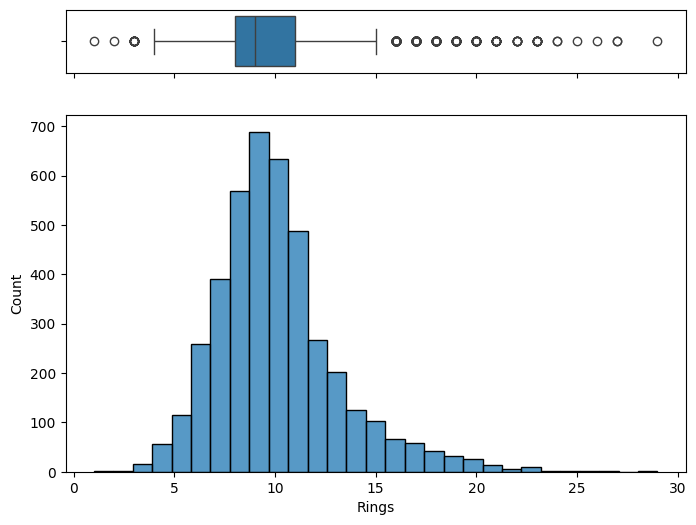

In [9]:
fig, (ax_box, ax_hist) = plt.subplots(
    2,
    figsize=(8, 6),
    dpi=100,
    sharex=True,
    gridspec_kw={"height_ratios": (0.15, 0.85)},
)
_ = sns.boxplot(data=data, x=target, ax=ax_box, orient="h")
_ = sns.histplot(data=data, x=target, ax=ax_hist, bins=29)

The small number of instances in the tails of the target distribution poses a problem: there isn't a way in which we can split the data while preserving each class's representation.

In [10]:
value_counts = data[target].value_counts()
value_counts.sort_index()

Rings
1       1
2       1
3      15
4      57
5     115
6     259
7     391
8     568
9     689
10    634
11    487
12    267
13    203
14    126
15    103
16     67
17     58
18     42
19     32
20     26
21     14
22      6
23      9
24      2
25      1
26      1
27      2
29      1
Name: count, dtype: int64

We can address this problem in at least two ways:

1. Hold the *rare* classes out in a test-only dataset. The model won't learn from those cases, but we'll still use them to measure the performance of the final model.
2. Map the under-represented classes into new, coarser labels, and use those classes during training and validation. In the case of this dataset, we could create a new coarse label for the abalones with *few* rings (say, less than 3 or 4) and another for the ones with *many* rings (for example, over 22 or 23).

### Feature variables

We see that, in this case, we also have distributions with long tails. Some of the values in the tails might be outliers. In particular, "Height" does look to have outliers.

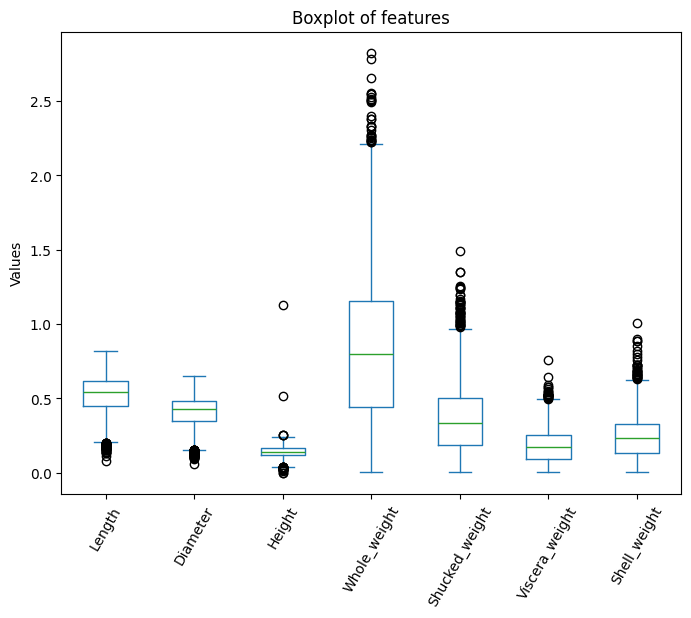

In [11]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
_ = data[features].plot.box(ax=ax, rot=60)
_ = ax.set_ylabel("Values")
_ = ax.set_title("Boxplot of features")

We confirm that at least two values in the "Height" variable are outliers by using a pair plot. These outliers are different from the records we found earlier that appear to have missing values encoded as 0.

The pair plot also shows that we need to use a model that can learn non-linear relationships: most of the pairings don't behave linearly.

This plot also shows that the variance isn't constant (the range within which the $y$-values vary changes for different values of $x$), breaking some standard models' assumptions. Should we use those models, we'll need stabilize the variance using a transformation. Or we can select a model that is unaffected by heteroscedasticy (variance that isn't constant).

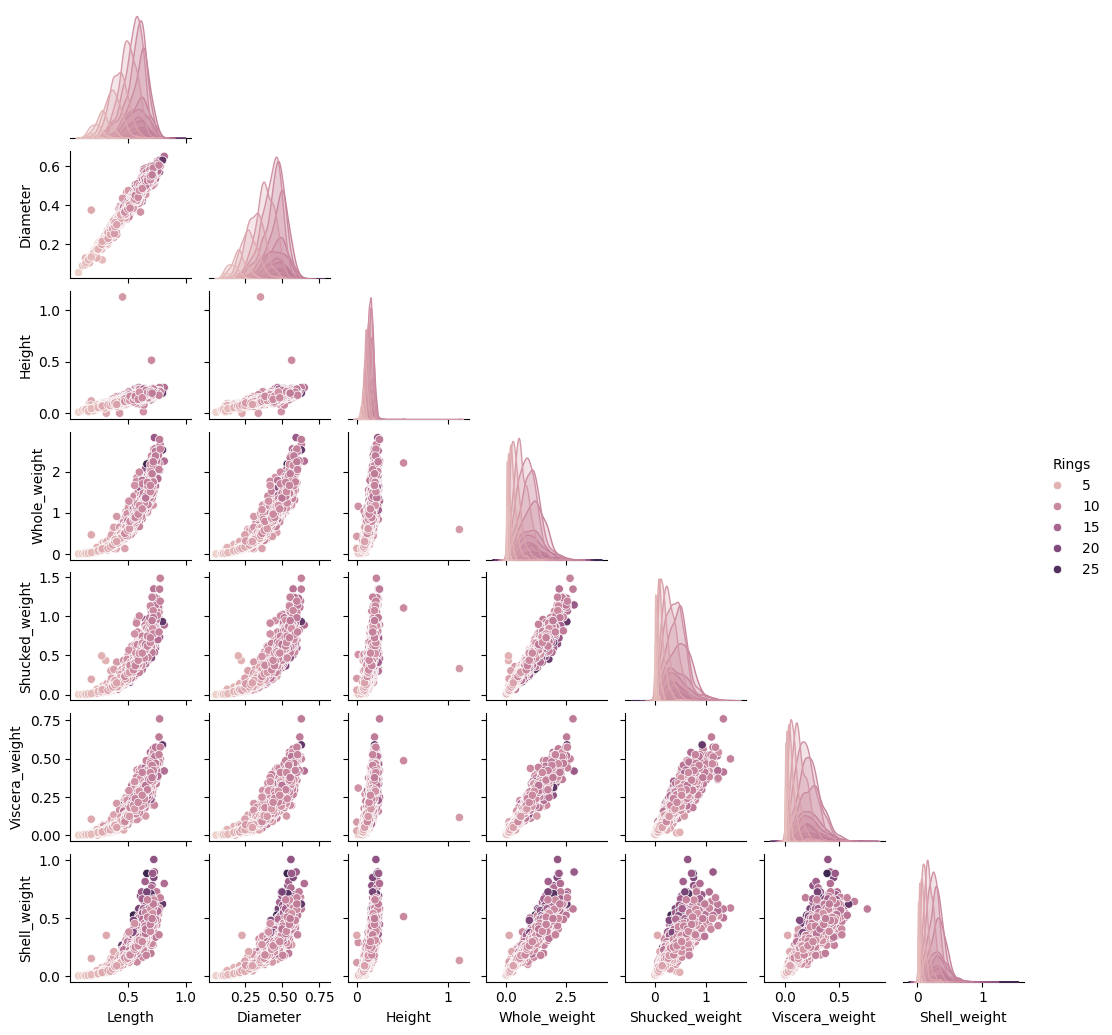

In [12]:
_ = sns.pairplot(data, hue="Rings", corner=True, height=1.5)

We see next that the extreme values in "Height" are over 0.5.

In [13]:
data["Height"].sort_values(ascending=False).head()

2051    1.130
1417    0.515
1428    0.250
1763    0.250
2179    0.250
Name: Height, dtype: float64

The "Heigh" records with "missing" and extreme values are associated with labels that are well represented in the dataset: 6, 8 and 10. Then, we should be able to safely drop them.

In [14]:
data[(data["Height"] == 0) | (data["Height"] > 0.5)]

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
1257,I,0.430,0.340,0.000,0.428,0.2065,0.0860,0.1150,8
1417,M,0.705,0.565,0.515,2.210,1.1075,0.4865,0.5120,10
2051,F,0.455,0.355,1.130,0.594,0.3320,0.1160,0.1335,8
3996,I,0.315,0.230,0.000,0.134,0.0575,0.0285,0.3505,6


The following is the pairplot when leaving out the extremes and zero values in "Height". There still seems to be more outliers, but we'll train the models with them nonetheless.

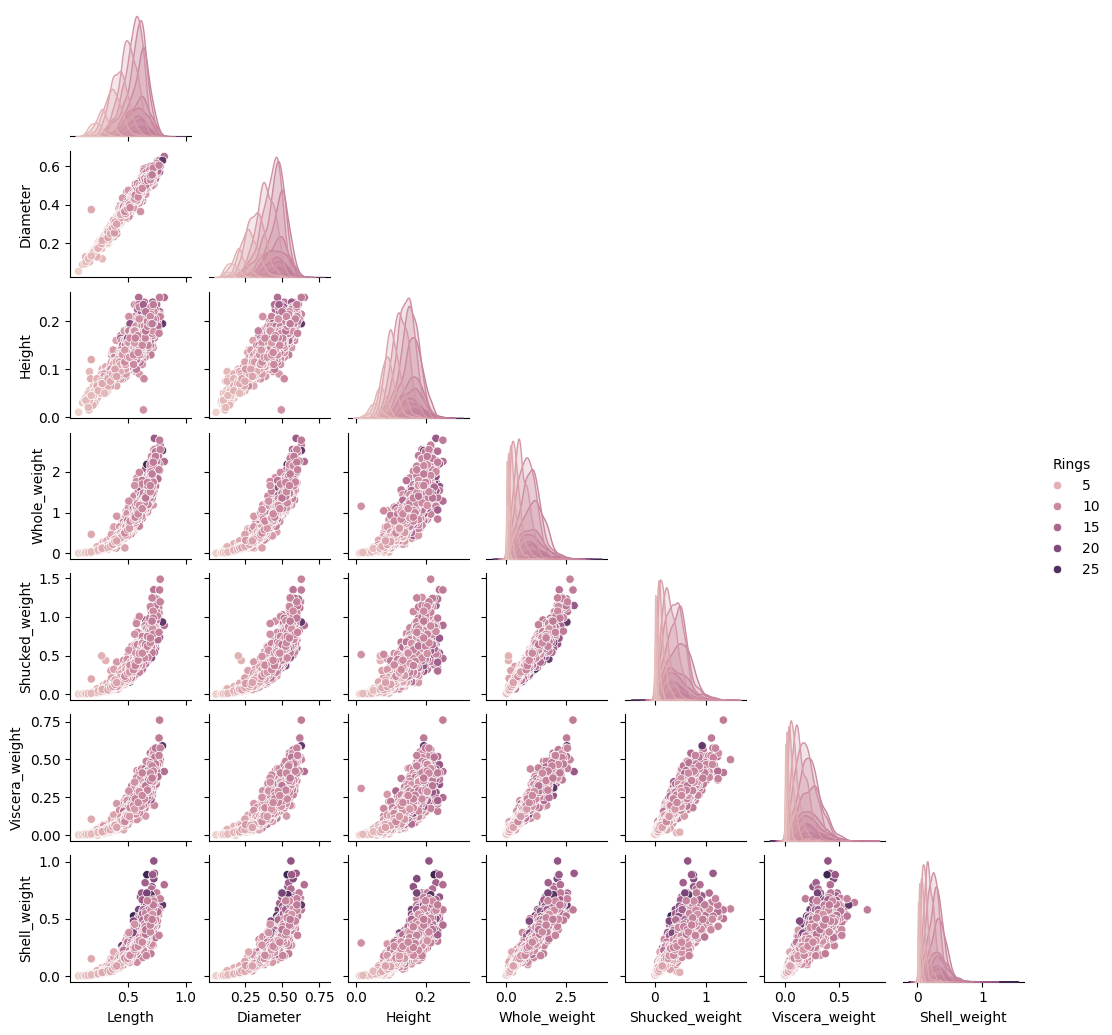

In [15]:
_ = sns.pairplot(
    data[(data["Height"] != 0) & (data["Height"] < 0.5)],
    hue="Rings",
    corner=True,
    height=1.5,
)

## Feature importance

We saw that the features don't behave linealy. Then, computing the Pearson correlation coefficient won't give us any meaningful information. We choose to compute mutual information instead.

In [16]:
# index of the columns that are categorical and index of the ones that are numeric
cat_idx = [0]
num_idx = list(range(1, 8))

# we only need to encode the categorical feature variables
ct = ColumnTransformer(
    transformers=[
        (
            "cat",
            OrdinalEncoder(),
            cat_idx,
        ),  # apply `OrdinalEncoder` to the categorical columns
        ("num", "passthrough", num_idx),  # leave numeric columns untouched
    ]
)

# using `OrdinalEncoder`, we don't create new columns: we associate an integer to each label
X_encoded = ct.fit_transform(data[features])

# we use `mutual_info_classif` because the target is discrete
# we have to tell `mutual_info_classif` which features are discrete, so we create a mask
discrete_mask = (data[features].dtypes == "object").to_numpy()
mi = mutual_info_classif(
    X_encoded, data[target].to_numpy(), discrete_features=discrete_mask
)

By computing the mutual information between each feature and the target variable we found that "Sex" is the feature that reduces the uncertainty in the target the least. If we choose to drop a feature to reduce the dimensionality of the problem, "Sex" might be a good candidate.

In [17]:
mi_feature_target = pd.Series(
    mi, index=data[features].columns, name="Mutual information"
).sort_values(ascending=False)
print(mi_feature_target)

Shell_weight      0.454013
Diameter          0.397777
Whole_weight      0.388954
Height            0.386428
Length            0.378266
Viscera_weight    0.370951
Shucked_weight    0.334046
Sex               0.162186
Name: Mutual information, dtype: float64


We can also compute the mutual information between the features themselves. Used well, this can point in the direction of features that are redundant. That is: if we have two features with a *high degree* of mutual information, we could drop one of them because both carry similar information.

The problem is in how to evaluate what constitutes a *high degree* of mutual information.

In [18]:
# initialize a list to store the results
n_combinations = comb(len(features), 2)
mi_feat = [[0 for _ in range(3)] for _ in range(n_combinations)]

# compute mutual information when one feature is discrete
for k, (cat, num) in enumerate(islice(combinations(range(8), 2), 7)):
    mi_xi_xj = mutual_info_classif(X_encoded[:, num].reshape(-1, 1), X_encoded[:, cat])[
        0
    ]
    mi_feat[k] = [features[cat], features[num], mi_xi_xj]

# compute mutual information when both features are continuous
for k, (x, y) in enumerate(islice(combinations(range(8), 2), 7, None)):
    mi_xi_xj = mutual_info_regression(X_encoded[:, x].reshape(-1, 1), X_encoded[:, y])[
        0
    ]
    mi_feat[k + len(features) - 1] = [features[x], features[y], mi_xi_xj]

mi_features = pd.DataFrame(
    mi_feat, columns=["feature_i", "feature_j", "mutual info"]
).sort_values(by="mutual info", ascending=False)

In [19]:
# sorted by mutual information value
# unfortunately, we can't compare these values directly
print(mi_features)

         feature_i       feature_j  mutual info
7           Length        Diameter     1.887500
22    Whole_weight  Shucked_weight     1.791316
14        Diameter    Whole_weight     1.692925
9           Length    Whole_weight     1.669720
23    Whole_weight  Viscera_weight     1.654850
24    Whole_weight    Shell_weight     1.640000
17        Diameter    Shell_weight     1.478198
10          Length  Shucked_weight     1.415788
12          Length    Shell_weight     1.403815
15        Diameter  Shucked_weight     1.349878
11          Length  Viscera_weight     1.337221
16        Diameter  Viscera_weight     1.290302
25  Shucked_weight  Viscera_weight     1.272789
27  Viscera_weight    Shell_weight     1.250223
26  Shucked_weight    Shell_weight     1.128527
21          Height    Shell_weight     1.048054
18          Height    Whole_weight     1.026295
20          Height  Viscera_weight     0.946103
13        Diameter          Height     0.943677
8           Length          Height     0

By estimating the mutual information scores between features, we find that some features appear to have a higher mutual information score between them than with the target.

But we can't really derive too much information from the values themselves. That the mutual information between "Length" and "Diameter" is 1.89, between "Length" and "Rings" (the target) is 0.38 and between "Diameter" and "Rings" is 0.42 don't necessarily mean that these features carry too little information to predict the target. That's because these values aren't normalized, so we don't know what the upper bound of the mutual information score is in each case. And that means that we can't meaninfully compare them. 

This also prevents us from knowing what a *high degree* of mutual information is. We can't compare mutual information scores as if they were correlations. Mutual information doesn't have an upper bound as clear cut as it is the case of correlations. We need to know the entropy of each of these features to normalize their mutual information scores because the thing that we do know is that the following holds:

$$I(X; Y) \leq \min (H(X), H(Y))$$

where $I(X; Y)$ is the mutual information between $X$ and $Y$ and $H(X)$ and $H(Y)$ are the entropies of $X$ and $Y$, respectively.

Mutual information between "Shell_weight", the variable that has the highest mutual information score with the target, and the other features:

In [20]:
important_feature = mi_feature_target.index[0]
print(important_feature)
print(
    mi_features[
        (mi_features.feature_i == important_feature)
        | (mi_features.feature_j == important_feature)
    ]
)

Shell_weight
         feature_i     feature_j  mutual info
24    Whole_weight  Shell_weight     1.640000
17        Diameter  Shell_weight     1.478198
12          Length  Shell_weight     1.403815
27  Viscera_weight  Shell_weight     1.250223
26  Shucked_weight  Shell_weight     1.128527
21          Height  Shell_weight     1.048054
6              Sex  Shell_weight     0.209049


Mutual information between "Diameter", the variable that has the second highest mutual information score with the target, and the other features:

In [21]:
important_feature = mi_feature_target.index[1]
print(important_feature)
print(
    mi_features[
        (mi_features.feature_i == important_feature)
        | (mi_features.feature_j == important_feature)
    ]
)

Diameter
   feature_i       feature_j  mutual info
7     Length        Diameter     1.887500
14  Diameter    Whole_weight     1.692925
17  Diameter    Shell_weight     1.478198
15  Diameter  Shucked_weight     1.349878
16  Diameter  Viscera_weight     1.290302
13  Diameter          Height     0.943677
1        Sex        Diameter     0.183632


And the mutual information between "Whole_weight", the variable that has the third highest mutual information score with the target, and the other features:

In [22]:
important_feature = mi_feature_target.index[2]
print(important_feature)
print(
    mi_features[
        (mi_features.feature_i == important_feature)
        | (mi_features.feature_j == important_feature)
    ]
)

Whole_weight
       feature_i       feature_j  mutual info
22  Whole_weight  Shucked_weight     1.791316
14      Diameter    Whole_weight     1.692925
9         Length    Whole_weight     1.669720
23  Whole_weight  Viscera_weight     1.654850
24  Whole_weight    Shell_weight     1.640000
18        Height    Whole_weight     1.026295
3            Sex    Whole_weight     0.202367


One way to [normalize the mutual information](https://en.wikipedia.org/wiki/Mutual_information#Normalized_variants) $I$ between random variables $X$ and $Y$, so we can compare the values of multiple mutual information scores, is the following:

$$\operatorname{NMI}(X, Y) = \frac{2 I(X; Y)}{H(X) + H(Y)}$$

where $\operatorname{NMI}(X, Y)$ is the normalized mutual information between $X$ and $Y$, $I(X; Y)$ is the mutual information between $X$ and $Y$ and $H(X)$ and $H(Y)$ are the entropies of $X$ and $Y$, respectively.

Unfortunately, we can't compute the entropy directly: we need to estimate it. And that's an involved process that isn't implemented neither in NumPy nor in Scikit-learn. In particular, mutual information in Scikit-learn is estimated using the k-nearest neighbors algorithm. We would need to use the same strategy to compute matching entropy estimators.

Because of the problem just highlighted, we leave the normalization of the mutual information score for a future work.

Note: the estimation of mutual information between two random variables has some degree of inherent randomness. The exact values of the computed mutual information scores cited here may change between runs.

# Data preparation

Trees aren't affected by the difference in magnitude of the features, so there's no need to normalize them as we do when using, for example, linear regression.

We'll discard the abnormal "Height" values and will train and validate using only the records for the target classes that have at least 3 samples.

In [23]:
# we create a boolean mask to get the records with classes whose frequency is over `freq_threshold`
freq_threshold = 3
mask_common_targets = data[target].isin(
    value_counts[value_counts >= freq_threshold].index
)

# we discard both the abnormal "Height" values and the under-represented classes for the working dataset
df = data[(data["Height"] != 0) & (data["Height"] < 0.5) & (mask_common_targets)].copy(
    deep=True
)

# we need to map the target values to the interval [0, 1, ..., #labels - 1]
le = LabelEncoder()
y = le.fit_transform(df[target])

# and we'll encode the "Sex" labels using integers without creating new columns
cat_idx, num_idx = [0], list(range(1, len(features)))
ct = ColumnTransformer(
    transformers=[
        (
            "cat",
            OrdinalEncoder(),
            cat_idx,
        ),  # apply `OrdinalEncoder` to the categorical columns
        ("num", "passthrough", num_idx),  # leave numeric columns untouched
    ]
)
X = ct.fit_transform(df[features])

# training, validation and test percentages
split = [60, 20, 20]
assert sum(split) == 100

# we choose to stratify the split to keep the same whole dataset class ratio in each partition
X_full_train, X_test, y_full_train, y_test = train_test_split(
    X, y, test_size=split[2] / 100, stratify=y
)

# we'll split the "full train" datasets once here
X_train, X_val, y_train, y_val = train_test_split(
    X_full_train,
    y_full_train,
    test_size=split[1] / (split[0] + split[1]),
    stratify=y_full_train,
)

# and we'll split it here multiple times using sklearn's `StratifiedKFold` for cross-validation
# we stratify the k-fold to keep the ratio of target classes in each partition
# the number of splits is round((split[0] + split[1]) / split[1]) to approximate the train and validation
# dataset percentages previously declared in `split`
folds = {}
skf = StratifiedKFold(n_splits=round((split[0] + split[1]) / split[1]), shuffle=True)
for fold, (train_idx, val_idx) in enumerate(skf.split(X_full_train, y_full_train), 1):
    folds[fold] = {
        "X_train": X_full_train[train_idx],
        "X_val": X_full_train[val_idx],
        "y_train": y_full_train[train_idx],
        "y_val": y_full_train[val_idx],
    }

# Modeling

## Baseline

### Random guess baseline

Given N clases, the F1 predicting performance of a model that guesses labels at random is 1 / N.

In [24]:
print(f"F1 score for a model that predicts labels randomly: {1 / len(le.classes_):.2f}")

F1 score for a model that predicts labels randomly: 0.05


## Gradient boosting using trees

In [25]:
xgb_starting_params = {
    "eta": 0.3,  # the default value
    "max_depth": 6,  # the default value
    "min_child_weight": 1,  # the default value
    "objective": "multi:softprob",  # to get the probabilities instead of the labels
    "num_class": len(le.classes_),  # number of classes to predict
    "eval_metric": "mlogloss",  # well-behaved function for the algorithm to track convergence
    "nthread": 7,  # number of local CPU cores minus 1
    "verbosity": 1,  # show warnings
}

In [26]:
def train_hyperparameter(
    train_hyperparam,
    hyperparam_values,
    folds,
    features,
    xgb_starting_params,
    num_boost_round=200,
    early_stopping_rounds=20,
):
    model_performance = np.zeros(
        2 * len(folds.keys()) * len(hyperparam_values)
    ).reshape(-1, 2)
    models = {}
    evals_result = {}

    for i, hyperparam in enumerate(hyperparam_values):
        evals_result[str(hyperparam)] = {}
        models[str(hyperparam)] = {}

        print(f"Training for {train_hyperparam} = {hyperparam}")
        xgb_params = {**xgb_starting_params, train_hyperparam: hyperparam}

        for j, (k, fold) in enumerate(tqdm(folds.items())):
            evals_result[str(hyperparam)][str(k)] = {}

            dtrain = xgb.DMatrix(
                fold["X_train"], label=fold["y_train"], feature_names=features
            )
            dval = xgb.DMatrix(
                fold["X_val"], label=fold["y_val"], feature_names=features
            )
            watchlist = [(dtrain, "train"), (dval, "val")]

            model = xgb.train(
                xgb_params,
                dtrain,
                num_boost_round=num_boost_round,  # max. number of boosting rounds
                early_stopping_rounds=early_stopping_rounds,  # stop training if the model isn't improving
                evals=watchlist,  # what to use to evaluate performance
                evals_result=evals_result[str(hyperparam)][
                    str(k)
                ],  # dict to store results
                verbose_eval=False,
            )

            predicted_probas = model.predict(dval)
            predicted_labels = predicted_probas.argmax(axis=1)
            macro_f1 = f1_score(fold["y_val"], predicted_labels, average="macro")

            model_performance[i * len(folds.keys()) + j, :] = [hyperparam, macro_f1]
            models[str(hyperparam)][str(k)] = model

    df_model_performance = pd.DataFrame(
        model_performance, columns=[train_hyperparam, "macro_f1"]
    )
    best_hyperparam = (
        df_model_performance.groupby(by=train_hyperparam)["macro_f1"].mean().idxmax()
    )

    return best_hyperparam, df_model_performance, models, evals_result

In [27]:
def train(
    X_train,
    X_validate,
    y_train,
    y_validate,
    features,
    xgb_params,
    num_boost_round=200,
    early_stopping_rounds=20,
):
    evals_result = {}

    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)

    dval = xgb.DMatrix(X_validate, label=y_validate, feature_names=features)
    watchlist = [(dtrain, "train"), (dval, "val")]

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round,  # max. number of boosting rounds
        early_stopping_rounds=early_stopping_rounds,  # stop training if the model isn't improving
        evals=watchlist,  # what to use to evaluate performance
        evals_result=evals_result,  # dict to store results
        verbose_eval=False,
    )

    predicted_probas = model.predict(dval)
    predicted_labels = predicted_probas.argmax(axis=1)
    macro_f1 = f1_score(y_validate, predicted_labels, average="macro")

    return macro_f1, model, evals_result

In [28]:
def plot_mlogloss(evals_result, hyperparam, fold_number, figsize=(10, 6), dpi=100):
    _, ax = plt.subplots(figsize=figsize, dpi=dpi)
    for hparam, metrics in evals_result.items():
        _ = ax.plot(metrics[str(fold_number)]["val"]["mlogloss"], label=hparam)
    _ = ax.legend()
    _ = ax.set_title(
        f"Multiclass log-loss for different '{hyperparam}' (fold #{fold_number})"
    )
    _ = ax.set_xlabel("iterations")
    _ = ax.set_ylabel("mlogloss")

In [29]:
def plot_macrof1(df_model_performance, hyperparam, figsize=(10, 6), dpi=100):
    _, ax = plt.subplots(figsize=figsize, dpi=dpi)
    for h_param_value, group in df_model_performance.groupby(hyperparam):
        _ = ax.scatter(group.iloc[:, 0], group.iloc[:, 1], label=h_param_value)
        _ = ax.scatter(
            group.iloc[0, 0],
            group.iloc[:, 1].mean(),
            marker="x",
            color=ax.collections[-1].get_facecolor()[0],
        )
    _ = ax.legend()
    _ = ax.set_title(
        f"Macro-F1 scores for different '{hyperparam}' and folds (intra-fold means denoted with an 'x')"
    )
    _ = ax.set_xlabel(hyperparam)
    _ = ax.set_ylabel("macro-f1")

### Training "eta"

In [30]:
etas = [0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1.0]
hyperparam = "eta"
best_eta, df_eta_model_performance, eta_models, eta_evals_result = train_hyperparameter(
    hyperparam, etas, folds, features, xgb_starting_params
)
print(f"Best '{hyperparam}': {best_eta}")

Training for eta = 0.01


100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


Training for eta = 0.05


100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


Training for eta = 0.1


100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


Training for eta = 0.3


100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Training for eta = 0.5


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Training for eta = 0.8


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


Training for eta = 1.0


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]

Best 'eta': 0.3


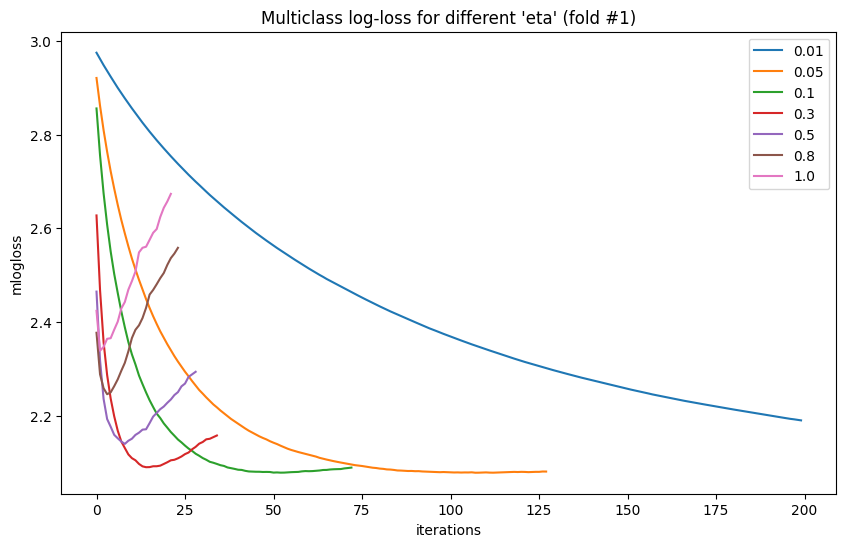

In [31]:
plot_mlogloss(eta_evals_result, "eta", 1)

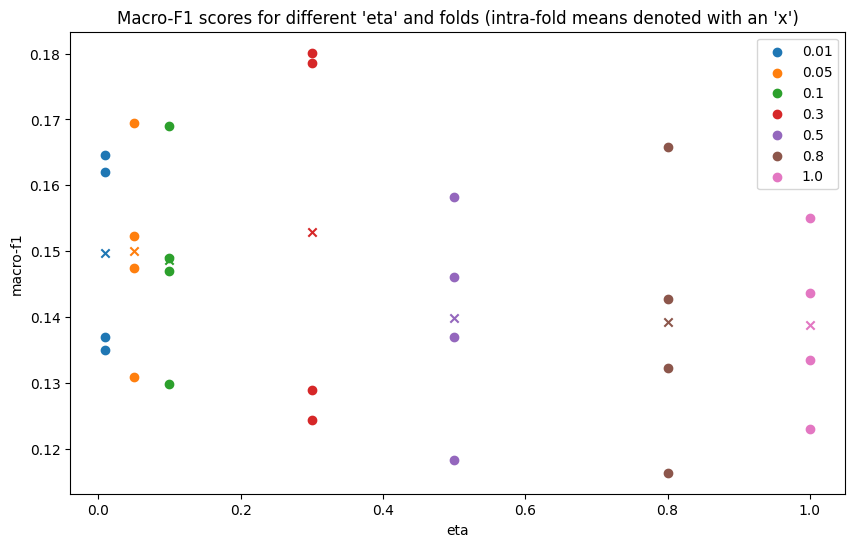

In [32]:
plot_macrof1(df_eta_model_performance, "eta")

### Training "max_depth"

In [33]:
max_depths = [3, 4, 6, 10]
hyperparam = "max_depth"
(
    best_max_depth,
    df_max_depth_model_performance,
    max_depth_models,
    max_depth_evals_result,
) = train_hyperparameter(
    hyperparam, max_depths, folds, features, {**xgb_starting_params, "eta": best_eta}
)
print(f"Best '{hyperparam}'={best_max_depth}")

Training for max_depth = 3


100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Training for max_depth = 4


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


Training for max_depth = 6


100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Training for max_depth = 10


100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

Best 'max_depth'=10.0


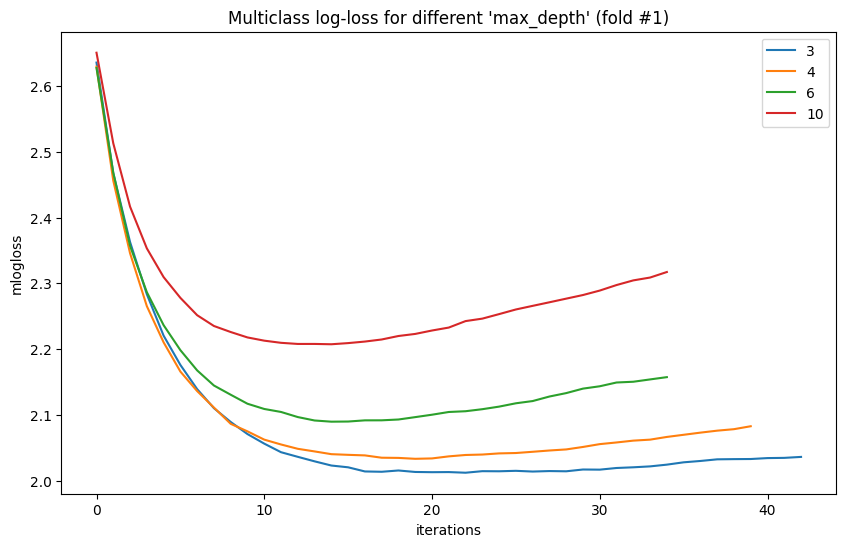

In [34]:
plot_mlogloss(max_depth_evals_result, "max_depth", 1)

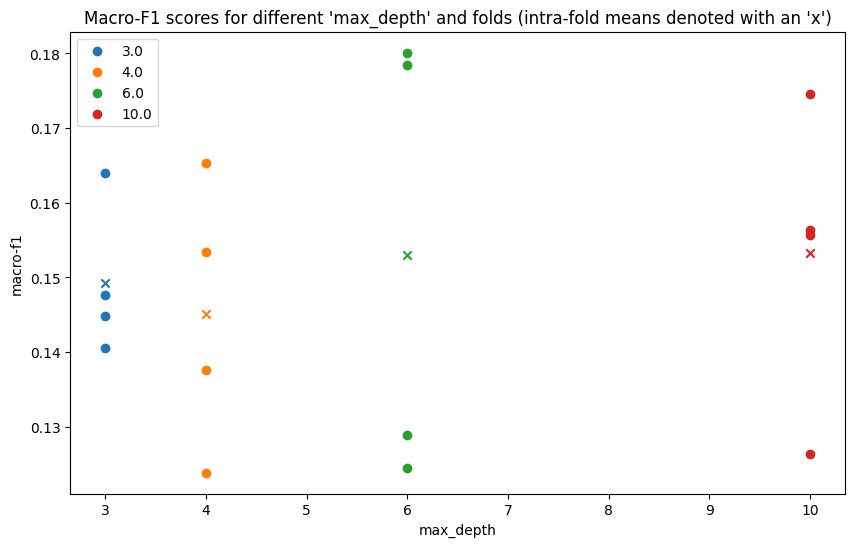

In [35]:
plot_macrof1(df_max_depth_model_performance, "max_depth")

### Training "min_child_weight"

In [36]:
min_child_weights = [1, 10, 30]
hyperparam = "min_child_weight"
(
    best_min_child_weight,
    df_min_child_weight_model_performance,
    min_child_weight_models,
    min_child_weight_evals_result,
) = train_hyperparameter(
    hyperparam,
    min_child_weights,
    folds,
    features,
    {**xgb_starting_params, "eta": best_eta, "max_depth": int(best_max_depth)},
)
print(f"Best '{hyperparam}'={best_min_child_weight}")

Training for min_child_weight = 1


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Training for min_child_weight = 10


100%|██████████| 4/4 [00:01<00:00,  3.08it/s]


Training for min_child_weight = 30


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

Best 'min_child_weight'=1.0


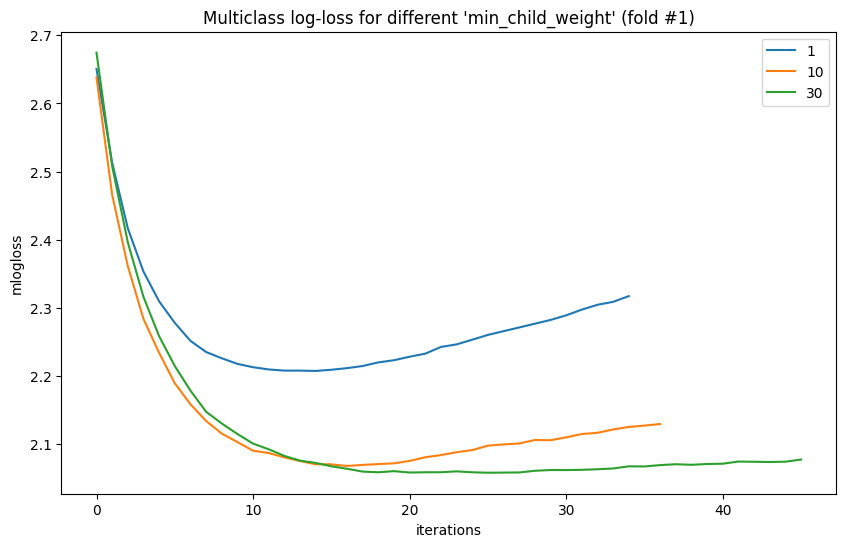

In [37]:
plot_mlogloss(min_child_weight_evals_result, "min_child_weight", 1)

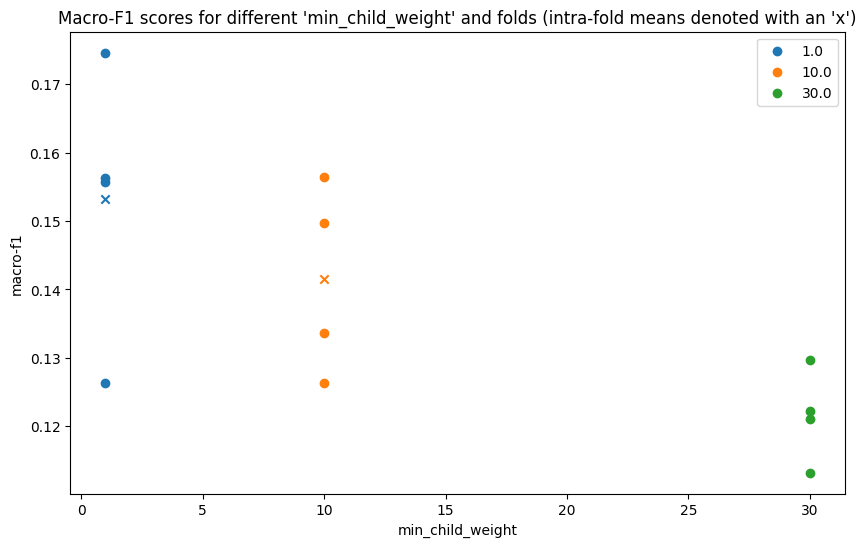

In [38]:
plot_macrof1(df_min_child_weight_model_performance, "min_child_weight")

### Training the final model with the best hyperparameters found

In [43]:
xgb_best = {
    "eta": best_eta,
    "max_depth": int(best_max_depth),
    "min_child_weight": best_min_child_weight,
}

macro_f1, model, evals_result = train(
    X_full_train,
    X_test,
    y_full_train,
    y_test,
    features,
    {**xgb_starting_params, **xgb_best},
)

In [44]:
print(f"Macro-F1 score: {macro_f1:.2f}")
print()
print("Best hyperparameters:")
for key, value in xgb_best.items():
    print(f"- {key}: {value}")

Macro-F1 score: 0.16

Best hyperparameters:
- eta: 0.3
- max_depth: 10
- min_child_weight: 1.0
